In [1]:
from google.colab import drive

# Check if drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted at /content/drive")

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/brain_tumor/Brain_Tumor_Aug_dataset.zip /content/

In [3]:
!ls /content/
!sudo apt-get install zip unzip

Brain_Tumor_Aug_dataset.zip  drive  sample_data
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zip is already the newest version (3.0-12build2).
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:

!unzip /content/Brain_Tumor_Aug_dataset.zip -d /content/brain_tumor

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0043_aug9.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/1311_aug8.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0100_aug0.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0224_aug8.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0394_aug2.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0288_aug5.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0143_aug9.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0691_aug5.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0670_aug6.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/1505_aug0.jpg  
  inflating: /content/brain_tumor/Brain_Tumor_Aug_dataset/meningioma/0903_aug8.jpg  
  inflating: /cont

In [5]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner.tuners import Hyperband
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


In [6]:
# Path to the main dataset directory
data_dir = "/content/brain_tumor/Brain_Tumor_Aug_dataset"

batch_size = 16
img_size = (224, 224)

# Load the training dataset (80% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,                       # Path to the dataset
    validation_split=0.2,          # Reserve 20% for validation
    subset="training",             # This is the training subset
    seed=42,                       # Random seed for reproducibility
    image_size=img_size,           # Resize all images to this size
    batch_size=batch_size,         # Number of samples per batch
    label_mode="categorical"       # One-hot encode the labels
)

# Load the validation dataset (20% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                       # Same dataset directory
    validation_split=0.2,          # 20% split for validation
    subset="validation",           # This is the validation subset
    seed=42,                        # Same seed to ensure consistency
    image_size=img_size,           # Resize images to match model input
    batch_size=batch_size,         # Same batch size as training
    label_mode="categorical"       # One-hot encoded labels
)
# Optimize performance using prefetching and shuffling
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # Shuffle and prefetch training data
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)                    # Prefetch validation data

Found 77253 files belonging to 4 classes.
Using 61803 files for training.
Found 77253 files belonging to 4 classes.
Using 15450 files for validation.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Define input layer with shape (224, 224, 3) for RGB images
    inputs = Input(shape=(224, 224, 3))
    x = inputs

    # Choose activation function as a hyperparameter
    activation = hp.Choice('activation', ['relu', 'tanh', 'swish'])

    # Add a variable number of convolutional layers (between 2 and 4)
    for i in range(hp.Int('conv_layers', 2, 4)):
        x = Conv2D(
            filters=hp.Choice(f'filters_{i}', [16, 32, 64, 128, 256]),  # Choose number of filters
            kernel_size=3,                                              # Kernel size fixed to 3x3
            activation=activation,                                     # Use selected activation function
            padding='same'                                             # Keep spatial dimensions
        )(x)
        x = MaxPooling2D(2)(x)  # Downsample using 2x2 max pooling

    # Flatten the output to feed into dense layers
    x = Flatten()(x)

    # Add a fully connected (dense) layer with tunable number of units
    dense_units = hp.Int('dense_units', 64, 256, step=32)
    x = Dense(dense_units, activation=activation)(x)

    # Add dropout for regularization, dropout rate is a hyperparameter
    x = Dropout(hp.Float('dropout', 0.2, 0.3, step=0.1))(x)

    # Output layer with 4 units (for 4 classes) and softmax activation
    class_output = Dense(4, activation='softmax', name='class_output')(x)

    # Choose learning rate as a hyperparameter
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])

    # Define the model and compile it
    model = Model(inputs=inputs, outputs=class_output)

    model.compile(
        optimizer=Adam(learning_rate),             # Use Adam optimizer with selected learning rate
        loss='categorical_crossentropy',           # Loss function for multi-class classification
        metrics=['accuracy']                       # Track accuracy during training
    )

    return model


In [ ]:
# Ensure the directory for the tuner exists
import os
tuner_directory = '/content/drive/MyDrive/brain_tumor/hyperparameter_trial'

# Create the directory if it doesn't already exist
if not os.path.exists(tuner_directory):
    os.makedirs(tuner_directory)

# Initialize the Hyperband tuner
tuner = kt.Hyperband(
    build_model,  # Function that builds the model
    objective=kt.Objective('val_accuracy', direction='max'),  # Optimize for highest validation accuracy
    max_epochs=5,        # Maximum number of epochs per trial
    factor=3,            # Reduction factor for the number of configurations
    directory=tuner_directory,  # Directory to save tuning results
    project_name='hyperparameter_trial'  # Subdirectory name for this tuning project
)


In [ ]:
# Define EarlyStopping callback to prevent overfitting and stop training early
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',         # Monitor validation accuracy
    patience=3,                     # Stop training if val_accuracy doesn't improve for 3 consecutive epochs
    restore_best_weights=True,     # Restore model weights from the epoch with the best val_accuracy
    mode='max'                      # Maximize the monitored metric
)


In [ ]:
# Perform hyperparameter search on the training dataset
tuner.search(
    train_ds,                # Training dataset
    epochs=4,                # Total number of epochs for training
    validation_data=val_ds,  # Validation dataset
    callbacks=[early_stop],  # Early stopping callback
)


Trial 10 Complete [01h 04m 43s]
val_accuracy: 0.8342394828796387

Best val_accuracy So Far: 0.8818770051002502
Total elapsed time: 02h 56m 28s


In [7]:
"""best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
"""


NameError: name 'tuner' is not defined

In [ ]:
# Retrieve the best trial from the hyperparameter tuning results
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

print(f"Best Trial ID: {best_trial.trial_id}")  # Print the ID of the best trial
print("Best Hyperparameters:")                   # Print the best hyperparameters found

for hp_name, hp_value in best_trial.hyperparameters.values.items():
    print(f"  {hp_name}: {hp_value}")            # Print each hyperparameter name and its value


Best Trial ID: 0005
Best Hyperparameters:
  activation: relu
  conv_layers: 3
  filters_0: 128
  filters_1: 64
  dense_units: 96
  dropout: 0.2
  learning_rate: 0.0001
  filters_2: 32
  filters_3: 32
  tuner/epochs: 5
  tuner/initial_epoch: 2
  tuner/bracket: 1
  tuner/round: 1
  tuner/trial_id: 0001


In [8]:
# File path to save the model with the best validation accuracy
best_model_path = "/content/drive/MyDrive/brain_tumor/final_model/best_model_final.keras"
# File path to save the latest checkpoint after every epoch
last_model_path = "/content/drive/MyDrive/brain_tumor/final_model/last_checkpoint_final.keras"

callbacks = [
    # Save the model weights only when validation accuracy improves
    ModelCheckpoint(filepath=best_model_path, monitor='val_accuracy',
                    save_best_only=True, verbose=1),
    # Save the model weights at the end of every epoch regardless of performance
    ModelCheckpoint(filepath=last_model_path, save_best_only=False),
    # Stop training early if validation loss does not improve for 5 epochs and restore best weights
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]



In [12]:
last_model = tf.keras.models.load_model('/content/drive/MyDrive/brain_tumor/final_model/last_checkpoint_final.keras')


In [13]:
# Continue training the model starting from epoch 9 up to 50 epochs
history = last_model.fit(
    train_ds,               # Training dataset
    validation_data=val_ds, # Validation dataset
    epochs=50,              # Total number of epochs to train
    initial_epoch=9,        # Start training from epoch 9 (useful for resuming training)
    callbacks=callbacks     # List of callbacks for checkpointing and early stopping
)


Epoch 10/50
3862/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9868 - loss: 0.0400
Epoch 10: val_accuracy did not improve from 0.88770
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 206s 50ms/step - accuracy: 0.9868 - loss: 0.0400 - val_accuracy: 0.8797 - val_loss: 0.6134
Epoch 11/50
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9865 - loss: 0.0407
Epoch 11: val_accuracy did not improve from 0.88770
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 195s 49ms/step - accuracy: 0.9865 - loss: 0.0407 - val_accuracy: 0.8872 - val_loss: 0.6666
Epoch 12/50
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9869 - loss: 0.0390
Epoch 12: val_accuracy did not improve from 0.88770
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 195s 49ms/step - accuracy: 0.9869 - loss: 0.0390 - val_accuracy: 0.8874 - val_loss: 0.6528
Epoch 13/50
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9885 - loss: 0.0363
Epoch 13: val_accuracy improved from 0.88770 to 0.89223, saving model to /content/drive/MyDrive/brain_tumor/final_mode

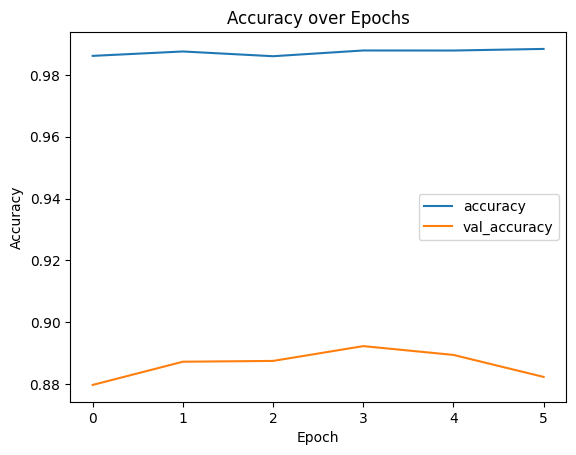

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')           # Training accuracy over epochs
plt.plot(history.history['val_accuracy'], label='val_accuracy')   # Validation accuracy over epochs
plt.xlabel('Epoch')                                                # X-axis label
plt.ylabel('Accuracy')                                             # Y-axis label
plt.legend()                                                      # Show legend
plt.title('Accuracy over Epochs')                                  # Graph title
plt.show()                                                        # Display the plot


MODEL-TEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

      glioma       1.00      0.86      0.92         7
     healthy       0.88      1.00      0.93         7
  meningioma       0.75      0.75      0.75         4
   pituitary       1.00      1.00      1.00         2

    accuracy                           0.90        20
   macro avg       0.91      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20



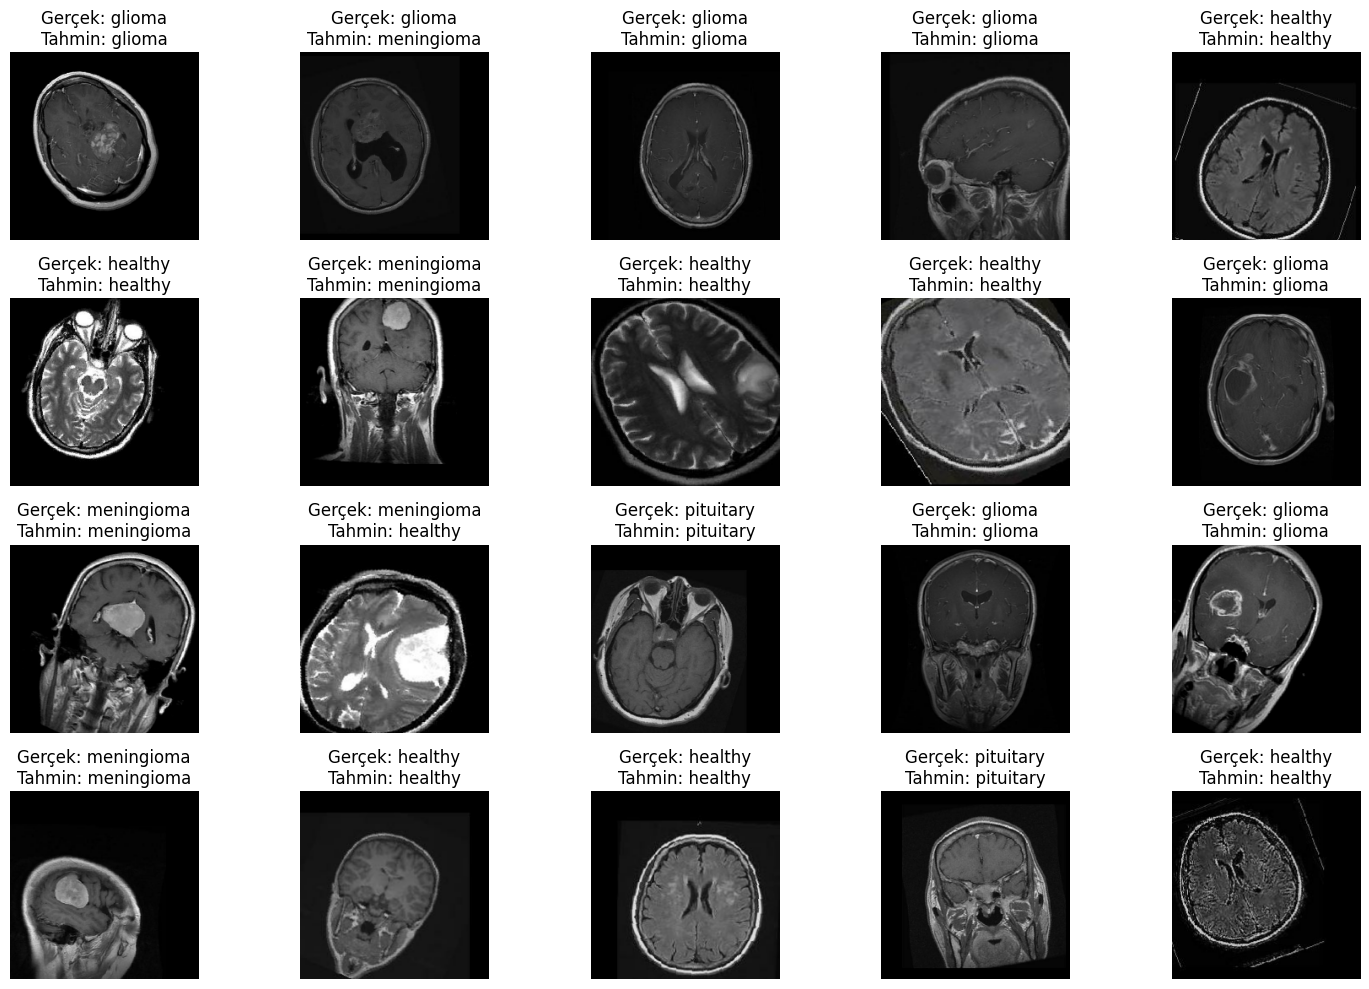

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

# Load the trained model
model = load_model("/content/drive/MyDrive/brain_tumor/final_model/best_model_final.keras")

# Get class names from the directory structure
data_dir = "/content/brain_tumor/Brain_Tumor_Aug_dataset"
class_names = sorted([name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))])

# Collect 20 sample images and labels from validation dataset
sample_images = []
sample_labels = []

for images, labels in val_ds.unbatch().take(20):
    sample_images.append(images.numpy())
    sample_labels.append(labels.numpy())

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Get predictions for sample images
preds = model.predict(sample_images)
y_pred = np.argmax(preds, axis=1)      # Predicted class indices
y_true = np.argmax(sample_labels, axis=1)  # True class indices

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Optional: Visualize the predictions
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.title(f"True: {class_names[y_true[i]]}\nPredicted: {class_names[y_pred[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
